In [1]:
using ProgressMeter
using JLD
using Random
include("../alpcahus.jl")
include("../helperFunctions.jl")
include("../cluster.jl")
include("../otherMethods.jl")
include("../adssc.jl")

lsr (generic function with 1 method)

In [2]:
pwd()

"/home/javier/Desktop/alpcahus/ssc"

# Generate data file for cross validation using Dereks repo

In [12]:
# subspace generation
U1 = generateSubspace(50, 3; seed=1234) 
U2 = generateSubspace(50, 3; seed=4321)
# data generation
X1 = generateData(U1, [0.1,300*0.1], [6,50*6]; seed=4231)
X2 = generateData(U2, [0.1,300*0.1], [6,50*6]; seed=1324)
# complete data matrix
X = hcat(X1,X2);
X = mapslices(normalize, X, dims=1)
# cluster assignments
trueLabels = vec([1*ones(size(X1)[2],1); 2*ones(size(X2)[2],1)]);

In [13]:
# A = ssc_omp(X,1000)
# A = 0.5*(A + A')
# estimatedClusters = spectralClustering(Matrix(A),2)
# clusterError(trueLabels, estimatedClusters)

In [14]:
#using MAT
#file = matopen("javier_data.mat", "w")
#write(file, "X", X)
#write(file, "label", trueLabels)
#close(file)

In [15]:
#n1 = 50 , n2= 0.1 best parameters across different situations
# X must be normalized however, otherwise gargabe results. Odd.
# normalize X below for this file only.

# Main experiment

In [2]:
D = 50 # ambient space dimension
d = 3 # subspace dimension
goodPoints = 6 # good points per subspace
ν1 = 0.1 # noise variance good points
K = 2 # subspace count
varianceRatio = range( 1,300,5) # variance ratio for heatmaps
pointRatio = range(1,50,5) # point ratio between good bad data for heatmaps
trials = 50; # smoother results
qValue = 24;

In [9]:
seedVector1 = rand(Xoshiro(1234), 1:100000, trials*length(varianceRatio)*length(pointRatio));
seedVector2 = rand(Xoshiro(4321), 1:100000, trials*length(varianceRatio)*length(pointRatio));
seedVector3 = rand(Xoshiro(2143), 1:100000, trials*length(varianceRatio)*length(pointRatio));
seedVector4 = rand(Xoshiro(3412), 1:100000, trials*length(varianceRatio)*length(pointRatio));

In [10]:
sscTensor = zeros(length(varianceRatio), length(pointRatio),trials)
alpcahTensor = zeros(length(varianceRatio), length(pointRatio),trials)
oracleTensor = zeros(length(varianceRatio), length(pointRatio),trials)

count = 1
@showprogress 1 "Running..." for i = 1:length(varianceRatio) # varianceRatio
     for j = 1:length(pointRatio) # prepend Threads.@threads for multi-threading
        for k = 1:trials
            # other parameters
            ν2 = varianceRatio[i]*ν1
            badPoints = round(Int, pointRatio[j]*goodPoints)
            # subspace generation
            U1 = generateSubspace(D, d; seed=seedVector1[count]) 
            U2 = generateSubspace(D, d; seed=seedVector2[count])
            # data generation
            X1 = generateData(U1, [ν1,ν2], [goodPoints,badPoints]; seed=seedVector3[count])
            X2 = generateData(U2, [ν1,ν2], [goodPoints,badPoints]; seed=seedVector4[count])
            # complete data matrix
            X = hcat(X1,X2);
            X = mapslices(normalize, X, dims=1)
            # cluster assignments
            trueLabels = vec([1*ones(size(X1)[2],1); 2*ones(size(X2)[2],1)]);
            # ssc trial function adssc(X::AbstractMatrix, η1::Number, η2::Number; η3::Number=0.0, return_C::Bool=false)
            A = adssc(X, 50, 0.1)
            A = 0.5*(A + A')
            estimatedCluster = spectralClustering(Matrix(A),2)
            sscTensor[i,j,k] = clusterError(trueLabels,estimatedCluster)
            # alpcahus trail
            estimatedCluster = ALPCAHUS(X,K, [d,d]; B=128, q=qValue, T=3, alpcahIter=20, subspaceMethod=:alpcah, finalStep=true, varfloor=1e-9, varianceMethod=:groupless) 
            alpcahTensor[i,j,k] = clusterError(trueLabels,estimatedCluster)
            # noisy oracle trial       
            noisyU1 = svd(X1[:,1:goodPoints]).U[:,1:d]
            noisyU2 = svd(X2[:,1:goodPoints]).U[:,1:d]
            estimatedCluster = clusterAssignment(X, [noisyU1, noisyU2], K)
            oracleTensor[i,j,k] = clusterError(trueLabels,estimatedCluster)
            # increase count
            count = count + 1
        end
    end
end

save("trialData.jld", "ssc", sscTensor, "alpcah", alpcahTensor, "oracle", oracleTensor);

Running... 100%|█████████████████████████████████████████| Time: 0:09:00


In [4]:
trialData = load("trialData.jld")
sscTensor = trialData["ssc"]
alpcahTensor = trialData["alpcah"]
oracleTensor = trialData["oracle"];

In [11]:
generateHeatmap(pointRatio, varianceRatio, sscTensor; plotType=:median, methodType="ADSSC", ν1=ν1, goodPoints=goodPoints)
savefig("adssc_median.pdf")

"/home/javier/Desktop/alpcahus/ssc/adssc_median.pdf"

In [12]:
generateHeatmap(pointRatio, varianceRatio, alpcahTensor; plotType=:median, methodType="ALPCAHUS", ν1=ν1, goodPoints=goodPoints)
savefig("alpcahus_median.pdf")

"/home/javier/Desktop/alpcahus/ssc/alpcahus_median.pdf"

In [13]:
generateHeatmap(pointRatio, varianceRatio, oracleTensor; plotType=:median, methodType="Noisy Oracle", ν1=ν1, goodPoints=goodPoints)
savefig("oracle_median.pdf")

"/home/javier/Desktop/alpcahus/ssc/oracle_median.pdf"

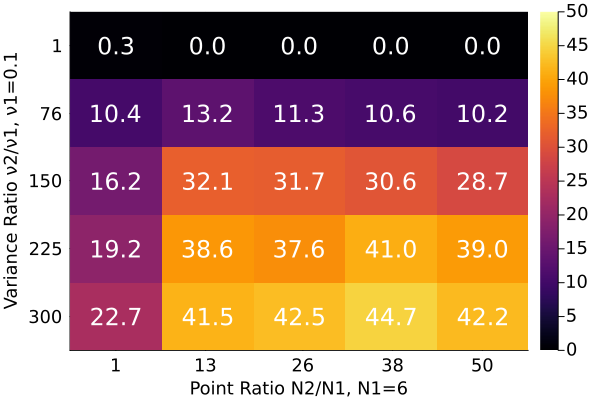

In [7]:
generateHeatmap(pointRatio, varianceRatio, sscTensor; plotType=:mean, methodType="ADSSC", ν1=ν1, goodPoints=goodPoints)
#savefig("adssc_mean.pdf")

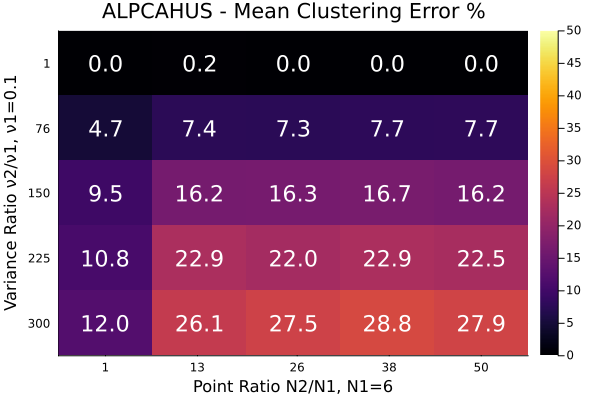

In [21]:
generateHeatmap(pointRatio, varianceRatio, alpcahTensor; plotType=:mean, methodType="ALPCAHUS", ν1=ν1, goodPoints=goodPoints)
#savefig("alpcahus_mean.pdf")

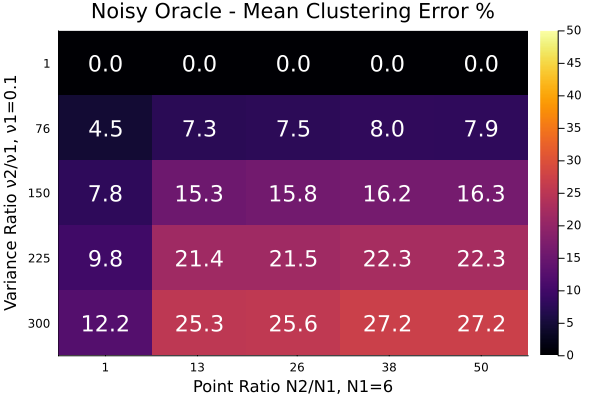

In [22]:
generateHeatmap(pointRatio, varianceRatio, oracleTensor; plotType=:mean, methodType="Noisy Oracle", ν1=ν1, goodPoints=goodPoints)
#savefig("oracle_mean.pdf")

In [17]:
generateHeatmap(pointRatio, varianceRatio, sscTensor; plotType=:variance, methodType="ADSSC", ν1=ν1, goodPoints=goodPoints)
savefig("adssc_variance.pdf")

"/home/javier/Desktop/alpcahus/ssc/adssc_variance.pdf"

In [18]:
generateHeatmap(pointRatio, varianceRatio, alpcahTensor; plotType=:variance, methodType="ALPCAHUS", ν1=ν1, goodPoints=goodPoints)
savefig("alpcahus_variance.pdf")

"/home/javier/Desktop/alpcahus/ssc/alpcahus_variance.pdf"

In [19]:
generateHeatmap(pointRatio, varianceRatio, oracleTensor; plotType=:variance, methodType="Noisy Oracle", ν1=ν1, goodPoints=goodPoints)
savefig("oracle_variance.pdf")

"/home/javier/Desktop/alpcahus/ssc/oracle_variance.pdf"